# Flock of birds test

From Shiflet & Shiflet

Rules:

* "Alignment" means that a bird tends to turn so that it is moving in the same direction that nearby birds are moving.

* "Separation" means that a bird will turn to avoid another bird which gets too close.

* "Cohesion" means that a bird will move towards other nearby birds (unless another bird is too close).

* When two birds are too close, the "separation" rule overrides the other two, which are deactivated until the minimum separation is achieved.

* If a bird isn't near another bird, it moves in a random direction (in this implementation, it moves toward the closest bird)

The three rules affect only the bird's heading. Each bird always moves forward at the same constant speed.

Note:  I've added a few simple embellishments to the code, so it's not *exactly* the "flock of birds" model. There's some random motion added to each bird at each timestep, for example, which is mostly aesthetic.

Misc relevant websites:
* [wikipedia article on flocking](https://en.wikipedia.org/wiki/Flocking_(behavior))
* [youtube vide of flock of birds simulation](https://www.youtube.com/watch?v=ozLacy8t3gw)
* [netlogo bird flock animation](http://ccl.northwestern.edu/netlogo/models/Flocking)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import display, clear_output
import time

In [2]:
# Note: All parameters are unitless

N_birds = 200  # number of birds
bird_neighborhood = 1.5  # radius of neighborhood around bird where it looks at other bird behavior
too_close = 0.25  # radius within which birds move away from each other
box_size = 40.0 # size of domain 
v_bird = 1.0  # velocity of each bird (each bird moves at a constant velocity)
t_end = 400.0  # end time of the simulation
dt = 0.5  # dt of simulation (each bird moves v_bird*dt per timestep)

In [3]:
def create_neighborhood(N_birds, box_size, v_bird):
    '''
    Assuming a square box size, populate it with N_birds at 
    random places, each of which has a speed v_bird pointing
    in a random direction.  Takes in number of birds, box size, 
    and bird velocity.  Outputs x/y position and velocity.
    '''
    
    # randomly give birds x and y locations
    x_pos = np.random.random(N_birds)*box_size
    y_pos = np.random.random(N_birds)*box_size

    x_vel = np.zeros(N_birds)
    y_vel = np.zeros(N_birds)
    
    # loop over birds and each gets a random velocity
    for i in range(N_birds):
        angle = np.random.random()*2.0*math.pi
        x_vel[i] = np.cos(angle)*v_bird
        y_vel[i] = np.sin(angle)*v_bird
        
    return x_pos, y_pos, x_vel, y_vel


def show_neighborhood(x_pos, y_pos, box_size, this_time=-1.0, saveplot=False, framenum=0):
    '''
    Plots the domain and all of the birds. Optionally, it writes the files into a 
    directory called "figs" (we want a subdirectory because each step gets written 
    into a frame).  This is meant to be plotted as an animation, so there are a few
    non-standard plotting things in here.  Takes in x/y position, box size, and optionally
    the simulation time, a flag to save plot, and frame number.  Outputs an image and 
    optionally a saved plot in png format.
    '''
    
    
    #time.sleep(0.1)         # Sleep for half a second to slow down the animation
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots

    # force box to be appropriately sized
    plt.xlim(0.0,box_size)
    plt.ylim(0.0,box_size)

    # plots each bird in sequence
    for i in range(x_pos.size):
        plt.plot(x_pos[i],y_pos[i],'.')
     
    # print the time
    if this_time > 0:
        time_string = '{:.2f}'.format(this_time)
        plt.text(1,1, time_string)
 
    # create sequential file name based on frame number and save it
    if saveplot:
        filename = 'figs/flock_of_birds_{:04d}.png'.format(framenum)
        plt.savefig(filename)

        
def choose_movement(x_pos, y_pos, x_vel, y_vel, box_size, bird_neighborhood, v_bird, too_close):
    '''
    Chooses a bird's movement based on other birds and resets the bird's velocity.  This
    is far and away the most complicated function in this code, since it's where the bird 
    motions are determined and it implements the model rules.
    Takes in bird positions and velocity, size of box, velocity of birds, and parameters 
    pertaining to the rules (bird neighborhood and the parameter that determines if birds
    are too close).  Outputs are modified velocities (not returned; they are changed in-place).
    '''

    # loop over all of the birds
    for i in range(x_pos.size):

        # used to accumulate velocities of all birds in the bird_neighborhood
        xv = 0.0  # neighbor vx
        yv = 0.0  # neighbor vy
        
        # used to calculate the distance and index of the closest bird
        mindist = 2*box_size
        minindex = -1
        
        
        '''
        Loop over all of the *other* birds (skipping this one), calculate distance, 
        and keeping track of all of the velocities of birds within the bird neighborhood
        as well as the closest bird.
        '''
        for j in range(x_pos.size):
            if i != j:
                
                # calculates distance
                dist = calc_dist(x_pos, y_pos, i, j, box_size)
                
                # if birds are within bird_neighborhood, keep track of their velocities
                # (to calculate the average)
                if dist < bird_neighborhood:
                    xv += x_vel[j]
                    yv += y_vel[j]
                
                # keep track of closest bird and its index
                if dist < mindist:
                    mindist = dist
                    minindex = j

        
        if mindist > bird_neighborhood:  
            # if closest bird is outside the neighborhood, head toward nearest bird
            # Note: this is not 100% accurate as it doesn't take into account periodicity,
            # but that actually doesn't come into play all that much.
            
            x_vel[i] = v_bird * (x_pos[minindex]-x_pos[i])/mindist
            y_vel[i] = v_bird * (y_pos[minindex]-y_pos[i])/mindist

        elif mindist <= bird_neighborhood and mindist >= too_close:
            # if closest bird is inside neighborhood but not too clost to the nearest
            # bird, head in the average direction of the other birds in the neighborhood
            
            x_vel[i] = v_bird*xv/(xv*xv+yv*yv)**0.5
            y_vel[i] = v_bird*yv/(xv*xv+yv*yv)**0.5

        else:
            # if we reach here we're too close, so move directly away from
            # the nearest bird
            x_vel[i] = -x_vel[minindex]
            y_vel[i] = -y_vel[minindex]
            
        # if something weird has happened (generally if two birds land at the same
        # place) we may end up with a NaN, so if that happens give bird a random
        # velocity
        if np.isnan(x_vel[i]) or np.isnan(y_vel[i]):
            angle = np.random.random()*2.0*math.pi
            x_vel[i] = v_bird*math.cos(angle)
            y_vel[i] = v_bird*math.sin(angle)

        # this adds a bit of randomness to each bird's motion, to make
        # the simulation more interesting.  It's not part of the canonical
        # "flock of birds" model, but was interesting so I did it.
        #x_vel[i] += 0.3*v_bird*np.random.uniform(-1.0,1.0)
        #y_vel[i] += 0.3*v_bird*np.random.uniform(-1.0,1.0)
        
        # renormalizes each bird's velocity so that it is uniform
        speed = (x_vel[i]**2 + y_vel[i]**2)**0.5
        x_vel[i] = v_bird*x_vel[i]/speed
        y_vel[i] = v_bird*y_vel[i]/speed
  
            
def calc_dist(x_pos, y_pos, bird1, bird2, box_size):
    '''
    calculates distance between two birds, taking into account the periodic
    nature of the box (in other words, try to figure the 'mimimum distance' assuming
    the box is periodic).  Takes in arrays of bird x,y positions, the indices of the two
    birds in the index, the box size, and the size of the bird neighborhood.  Returns
    a distance.
    '''
    dist = ((x_pos[bird1]-x_pos[bird2])**2 + (y_pos[bird1]-y_pos[bird2])**2)**0.5
    
    # if birds are far away using naive distance estimator, test for distance assuming periodicity 
    if dist > (0.5*box_size):

        # mirror in the x direction, y direcdtion, and both directions.
        dist1 = ((x_pos[bird1]-x_pos[bird2]-box_size)**2 + (y_pos[bird1]-y_pos[bird2])**2)**0.5
        dist2 = ((x_pos[bird1]-x_pos[bird2])**2 + (y_pos[bird1]-y_pos[bird2]-box_size)**2)**0.5
        dist3 = ((x_pos[bird1]-x_pos[bird2]-box_size)**2 + (y_pos[bird1]-y_pos[bird2]-box_size)**2)**0.5
        
        # find smallest distance of four (original + 3 modified distances)
        if dist1 < dist:
            dist = dist1
        if dist2 < dist:
            dist = dist2
        if dist3 < dist:
            dist = dist3

    return dist

def move_birds(x_pos, y_pos, x_vel, y_vel, box_size, dt):
    '''
    Move birds forward by one step (v_bird*dt), looping them around the grid if they
    go off the edge.  Takes in bird positions and velocities, box size, and time step.
    There are no returns; the positions are modified in situ.
    '''
    
    # loop over all birds in array
    for i in range(x_pos.size):
        
        # update positions
        x_pos[i] += x_vel[i]*dt
        y_pos[i] += y_vel[i]*dt
        
        # check for periodicity.  If position is outside of box, 
        # update appropriately 
        
        if x_pos[i] > box_size:
            x_pos[i] -= box_size

        if x_pos[i] < 0.0:
            x_pos[i] += box_size

        if y_pos[i] > box_size:
            y_pos[i] -= box_size

        if y_pos[i] < 0.0:
            y_pos[i] += box_size


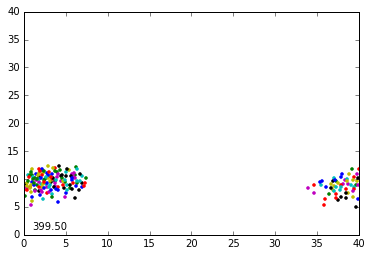

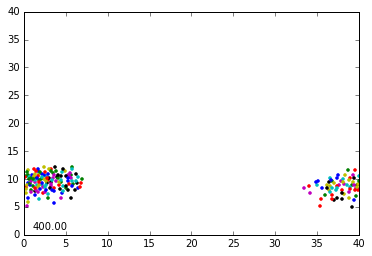

In [4]:
# create neighborhood
x,y,vx,vy = create_neighborhood(N_birds, box_size, v_bird)

# keep track of time and step
t = 0
step = 1

# make a figure - necessary for animation
fig = plt.figure()

# loop until the end of the simulation
while t <= t_end:

    # figure out where the bird should move
    choose_movement(x,y,vx,vy, box_size, bird_neighborhood, v_bird, too_close)

    # move the birds forward!
    move_birds(x,y,vx,vy,box_size,dt)

    # make an image
    show_neighborhood(x,y,box_size,t, saveplot=True,framenum=step)

    # update time and number of timesteps
    t += dt
    step += 1
